In [1]:
import pandas as pd
import numpy as np, os
import matplotlib.pyplot as plt

from pathlib import Path

import gbd_mapping as gm
from vivarium import Artifact

from db_queries import get_ids, get_outputs, get_population, get_covariate_estimates
from get_draws.api import get_draws

!date
!whoami
!pwd

Thu Aug 14 06:04:31 PDT 2025
lutzes
/mnt/share/homes/lutzes/vivarium_research_alzheimers/verification_and_validation


## V&V List from Docs 
- Verify that all simulants in the model have AD (i.e., all recorded person-time is in the “AD” state, not the “susceptible” state)
- Verify that there are no transitions between AD states during the simulation (since it’s an SI model and all simulants should be in the I state the whole time)
- Verify total sim mortality against artifact (ACMR - CSMR + EMR)
- Validate Alzheimer’s EMR against GBD
- Verify the number of new simulants per year against the AD population model
- Use interactive sim to verify initial population structure against the AD population model
- For comparison with model 1, calculate total “real world” Alzheimer’s population over time (I’m not sure how closely we expect this to match model 1)

# Load Data

In [34]:
locations = ['united_states_of_america', 'china']

results_dir_prefix = '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/'

results_dirs = [
    results_dir_prefix + 'results/model2.2/united_states_of_america/2025_08_13_15_59_41/results/',
    results_dir_prefix + 'results/model2.2/china/2025_08_13_16_14_43/results/'
]

artifact_dirs = [results_dir_prefix + 'artifacts/model1.0/' + x + '.hdf' for x in locations]
artifact_dirs

['/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model1.0/united_states_of_america.hdf',
 '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model1.0/china.hdf']

In [3]:
[x for x in os.listdir(results_dirs[0]) if 'parquet' in x]

['deaths.parquet',
 'ylls.parquet',
 'new_simulants.parquet',
 'transition_count_alzheimers_disease_and_other_dementias.parquet',
 'ylds.parquet',
 'person_time_alzheimers_disease_and_other_dementias.parquet']

In [4]:
age_group_ids = [11,12,13,14,15,16,17,18,19,20,30,31,32,33]
art = Artifact(artifact_dirs[0], filter_terms = ['year_start==2021'])

age_dictionary = pd.DataFrame()
age_dictionary['age_group_id'] = age_group_ids
age_dictionary = age_dictionary.merge(get_ids('age_group'), on='age_group_id')
age_dictionary['age_group'] = age_dictionary.age_group_name.str.lower().str.replace(' ', '_')
artifact = art.load('population.structure').reset_index()
artifact = artifact.loc[artifact.age_start > 29].reset_index()
age_dictionary['age_start'] = artifact.age_start
age_dictionary['age_end'] = artifact.age_end
age_dictionary.head()

,age_group_id,age_group_name,age_group,age_start,age_end
0,11,30 to 34,30_to_34,30.0,35.0
1,12,35 to 39,35_to_39,35.0,40.0
2,13,40 to 44,40_to_44,40.0,45.0
3,14,45 to 49,45_to_49,45.0,50.0
4,15,50 to 54,50_to_54,50.0,55.0


## Verify that all simulants in the model have AD 

In [5]:
def load_df(measure):
    data = pd.DataFrame()
    for results_dir in results_dirs:
        temp = pd.read_parquet(results_dir + measure + '.parquet')
        temp['location'] = locations[results_dirs.index(results_dir)].title()
        data = pd.concat([data, temp], ignore_index=True)
    return data

In [6]:
person_time = load_df('person_time_alzheimers_disease_and_other_dementias')
person_time.loc[person_time.sub_entity == 'susceptible_to_alzheimers_disease_and_other_dementias'].value.sum()

0.0

Yay!

## Verify that there are no transitions between AD states during the simulation 

In [7]:
def load_df(measure):
    data = pd.DataFrame()
    for results_dir in results_dirs:
        temp = pd.read_parquet(results_dir + measure + '.parquet')
        temp['location'] = locations[results_dirs.index(results_dir)].title()
        data = pd.concat([data, temp], ignore_index=True)
    return data

In [8]:
trans = load_df('transition_count_alzheimers_disease_and_other_dementias')
trans.loc[trans.sub_entity == 'susceptible_to_alzheimers_disease_and_other_dementias_to_alzheimers_disease_and_other_dementias'].value.sum()

0.0

Woohoo!

## Verify Total Sim Mortality against artifact (ACMR - CSMR + EMR)

In [9]:
cols = ['input_draw','current_year','location','age_group','sex']

def calculate_acmr():
    person_time_total = load_df('person_time_alzheimers_disease_and_other_dementias')
    total_pt = person_time_total.groupby(cols).sum()

    deaths = load_df('deaths')
    deaths = deaths.groupby(cols).sum()

    acmr = (deaths / total_pt)[['value']].reset_index()

    acmr = acmr.merge(age_dictionary, on=['age_group'])
    acmr = acmr.loc[acmr['age_group_id'].isin(age_group_ids)]
    acmr = acmr.groupby([c for c in cols if c != 'input_draw'] + ['age_start']).describe(percentiles=[0.025,0.975])['value'].reset_index()
    return acmr

sim_acmr = calculate_acmr()

/tmp/ipykernel_376917/3885451193.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  total_pt = person_time_total.groupby(cols).sum()
/tmp/ipykernel_376917/3885451193.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  deaths = deaths.groupby(cols).sum()


In [11]:
art_acmr = pd.DataFrame()
for artifact_dir in artifact_dirs:
    art = Artifact(artifact_dir, filter_terms = ['year_start==2021'])
    data = (art.load(f'cause.all_causes.cause_specific_mortality_rate') - art.load(f'cause.alzheimers_disease_and_other_dementias.cause_specific_mortality_rate') + art.load(f'cause.alzheimers_disease_and_other_dementias.excess_mortality_rate'))
    data = (data.apply(pd.DataFrame.describe, percentiles=[0.025, 0.975], axis=1)
            .filter(['mean', '2.5%', '97.5%']).reset_index())
    data = data.merge(age_dictionary, on=['age_start','age_end'])
    data = data.loc[data['age_group_id'].isin(age_group_ids)]
    data['measure'] = 'acmr'
    data['location'] = locations[artifact_dirs.index(artifact_dir)].title()
    art_acmr = pd.concat([art_acmr, data])
#art_acmr.head()

In [47]:
def age_group_plot(measure, sim_data, art_data):
    for location in sim_data.location.unique():
        for year in ['2030','2060','2090']:
            for sex in sim_data.sex.unique():
                plot_data = sim_data.loc[(sim_data.location == location) & (sim_data.current_year == year) & (sim_data.sex == sex)]
                art_plot = art_data.loc[(art_data.location == location) & (art_data.sex == sex)]

                plt.plot(plot_data.age_start, plot_data['mean'], label=f'Simulation {sex}')
                plt.fill_between(plot_data.age_start, plot_data['2.5%'], plot_data['97.5%'], alpha=0.2)

                plt.plot(art_plot.age_start, art_plot['mean'], label=f'Artifact {sex}')
                plt.fill_between(art_plot.age_start, art_plot['2.5%'], art_plot['97.5%'], alpha=0.2)

                plt.title(f"{measure} in {location} in {year}")
                plt.tick_params(axis='x', labelrotation=90)
                plt.xlabel("Age Group")
                plt.ylabel(f"{measure}")
                plt.legend()
            plt.figure()

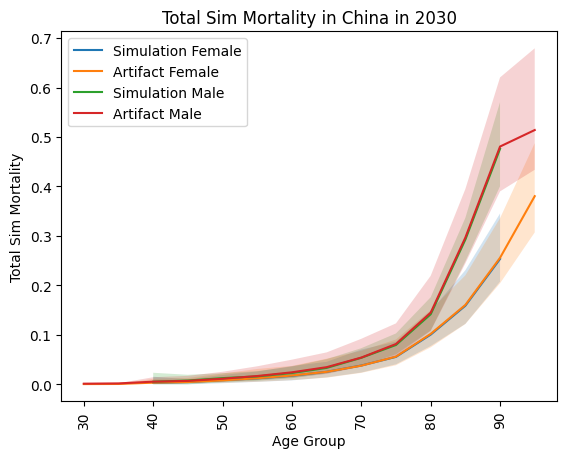

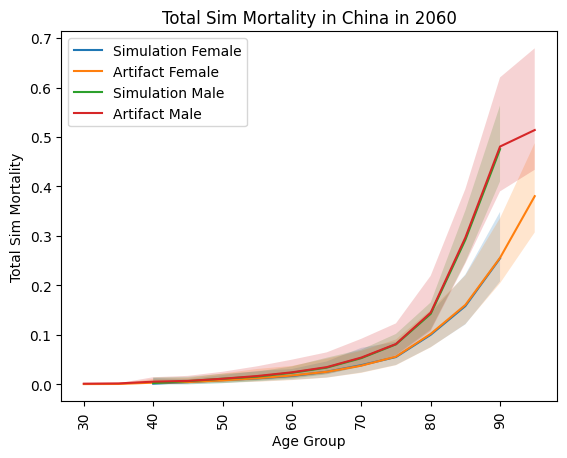

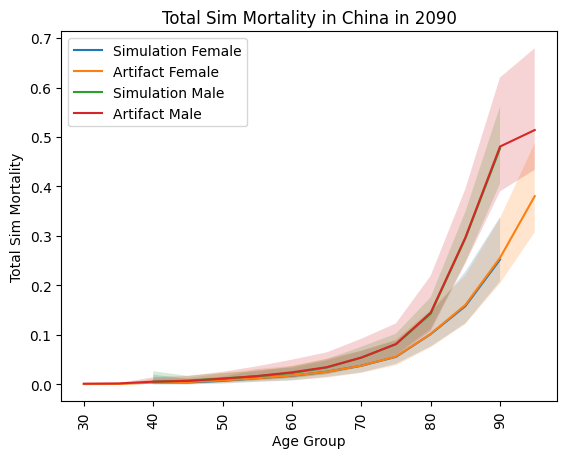

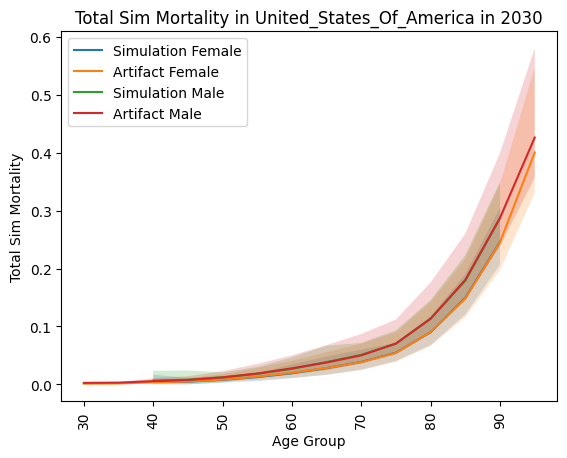

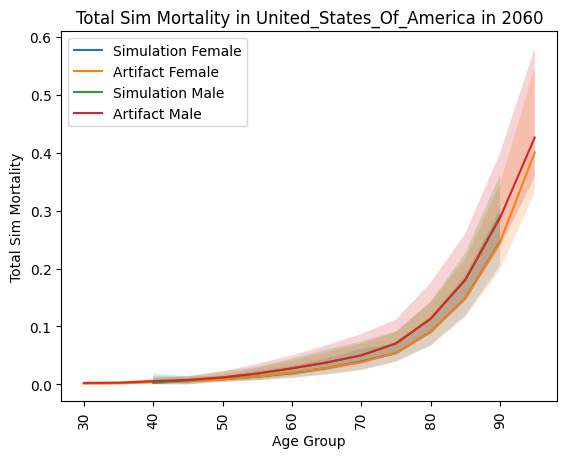

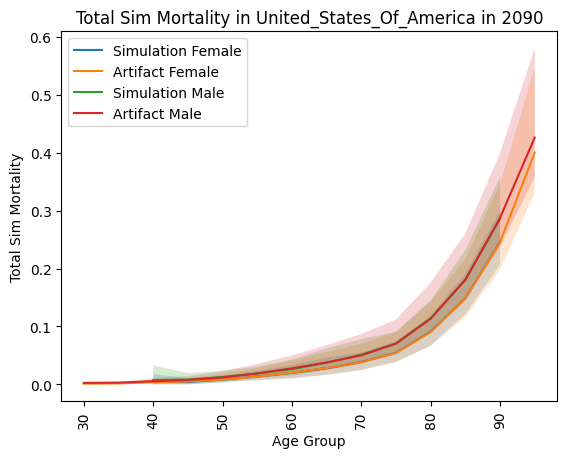

<Figure size 640x480 with 0 Axes>

In [48]:
age_group_plot('Total Sim Mortality', sim_acmr, art_acmr)

In [15]:
def over_time_plot(measure, sim_data, age_start):
    for location in sim_data.location.unique():
        for sex in sim_data.sex.unique():
            plot_data = sim_data.loc[(sim_data.location == location) & (sim_data.age_start == age_start) & (sim_data.sex == sex)]

            plt.plot(plot_data.current_year, plot_data['mean'], label=f'Simulation {sex}')
            plt.fill_between(plot_data.current_year, plot_data['2.5%'], plot_data['97.5%'], alpha=0.2)

            plt.title(f"{measure} in {location} Over Time Among Age Start Group {age_start}")
            plt.tick_params(axis='x', labelrotation=90)
            plt.xlabel("Year")
            plt.ylabel(f"{measure}")
            plt.legend()
        plt.figure()

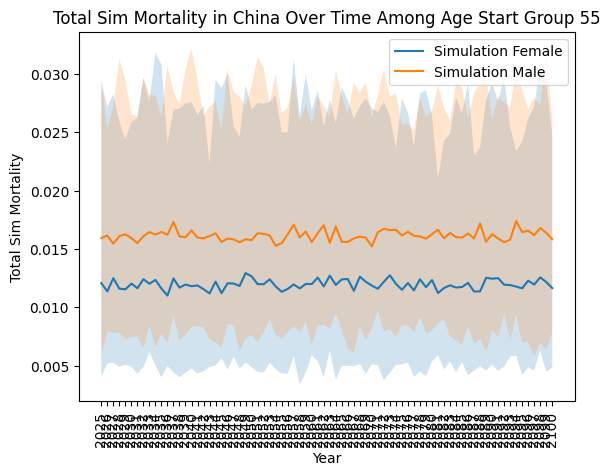

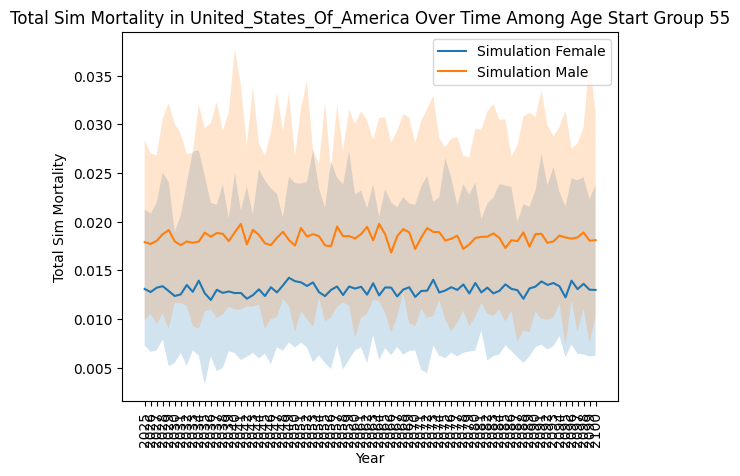

<Figure size 640x480 with 0 Axes>

In [16]:
over_time_plot('Total Sim Mortality', sim_acmr, 55)

## Validate Alzheimer’s EMR against GBD

In [17]:
cols = ['input_draw','current_year','location','age_group','sex']

def calculate_emr():
    person_time_total = load_df('person_time_alzheimers_disease_and_other_dementias')
    infected = person_time_total.loc[person_time_total.sub_entity == 'alzheimers_disease_and_other_dementias'].groupby(cols).sum()

    deaths = load_df('deaths')
    deaths = deaths.loc[deaths.sub_entity == 'alzheimers_disease_and_other_dementias'].groupby(cols).sum()

    acmr = (deaths / infected)[['value']].reset_index()

    acmr = acmr.merge(age_dictionary, on=['age_group'])
    acmr = acmr.loc[acmr['age_group_id'].isin(age_group_ids)]
    acmr = acmr.groupby([c for c in cols if c != 'input_draw'] + ['age_start']).describe(percentiles=[0.025,0.975])['value'].reset_index()
    return acmr

sim_emr = calculate_emr()

/tmp/ipykernel_376917/82446670.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  infected = person_time_total.loc[person_time_total.sub_entity == 'alzheimers_disease_and_other_dementias'].groupby(cols).sum()
/tmp/ipykernel_376917/82446670.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  deaths = deaths.loc[deaths.sub_entity == 'alzheimers_disease_and_other_dementias'].groupby(cols).sum()


In [20]:
def load_artifact_cause_data(measure):
    out = pd.DataFrame()
    for artifact_dir in artifact_dirs:
        art = Artifact(artifact_dir, filter_terms = ['year_start==2021'])
        data = art.load(f'cause.alzheimers_disease_and_other_dementias.{measure}')
        data = (data.apply(pd.DataFrame.describe, percentiles=[0.025, 0.975], axis=1)
                .filter(['mean', '2.5%', '97.5%']).reset_index())
        data = data.merge(age_dictionary, on=['age_start','age_end'])
        data = data.loc[data['age_group_id'].isin(age_group_ids)]
        data['measure'] = measure
        data['location'] = locations[artifact_dirs.index(artifact_dir)].title()
        out = pd.concat([out, data])
    return out

In [21]:
art_emr = load_artifact_cause_data('excess_mortality_rate')
#art_emr.head()

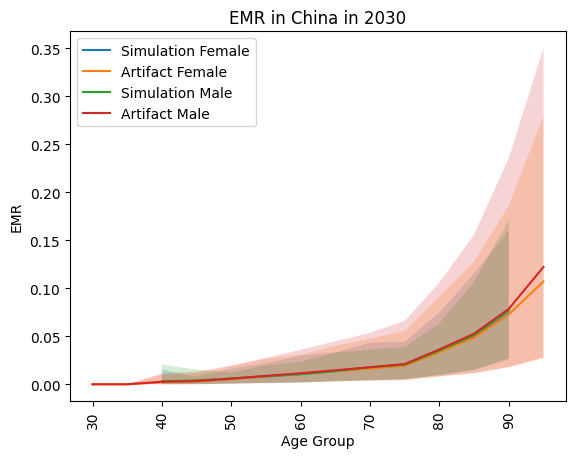

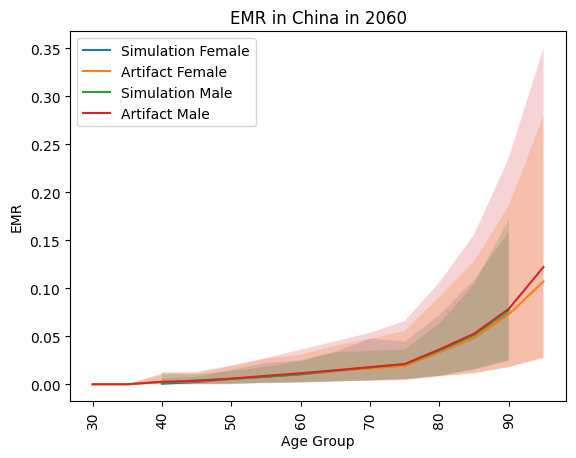

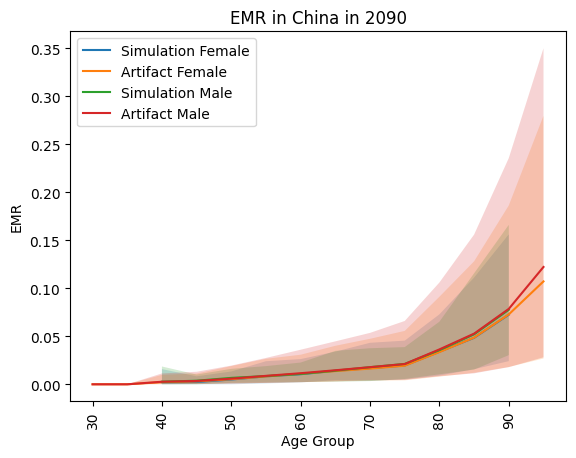

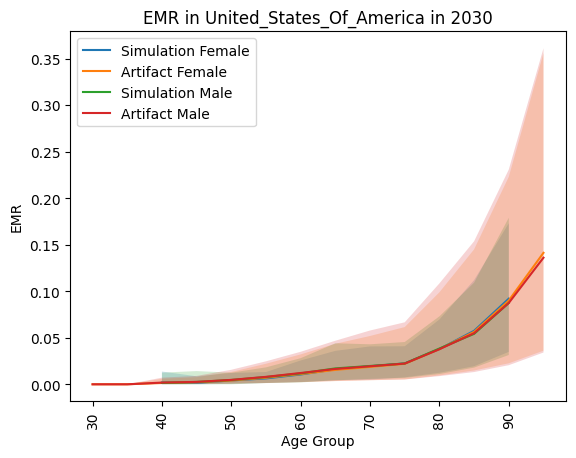

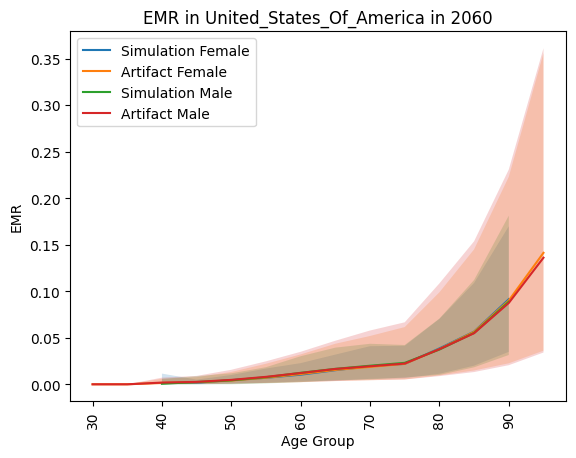

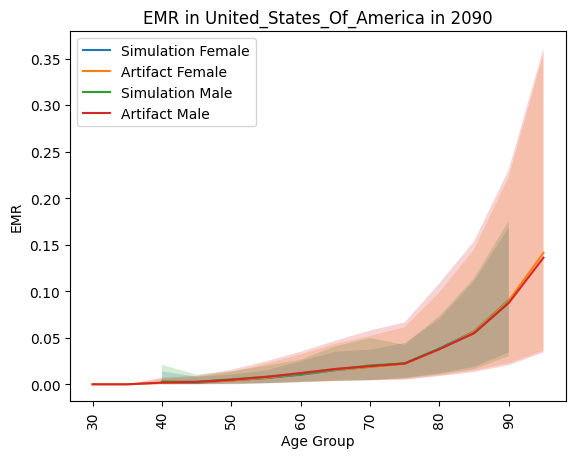

<Figure size 640x480 with 0 Axes>

In [49]:
age_group_plot('EMR', sim_emr, art_emr)

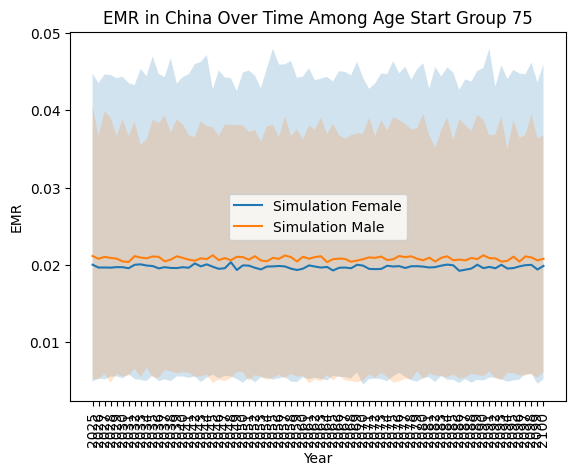

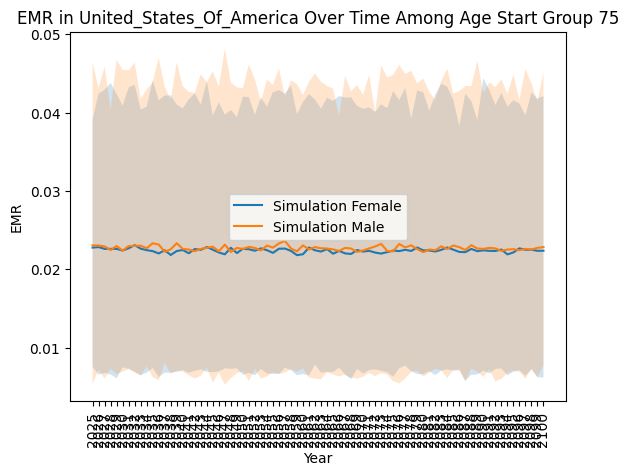

<Figure size 640x480 with 0 Axes>

In [23]:
over_time_plot('EMR', sim_emr, 75)

## Verify the number of new simulants per year against the AD population model

In [31]:
sex_ids = [1,2]
location_ids = [6,102]

gbd_data = get_outputs(topic='cause',
                      year_id=2021,
                      sex_id=sex_ids,
                      age_group_id=age_group_ids,
                      location_id=location_ids,
                      cause_id=543,
                      measure_id=[5,6],
                      metric_id=1,
                      release_id=9)
gbd_data['measure'] = gbd_data.measure_name.str.split(' ', expand=True)[0].str.lower()
gbd_data['location_name'] = gbd_data.location_name.str.replace(' ', '_').str.title()
gbd_data = gbd_data.merge(age_dictionary, on=['age_group_id','age_group_name'])
gbd_data.head()

/ihme/homes/lutzes/.conda/envs/mncnh_vv/lib/python3.11/site-packages/ihme_cc_rules_client/lib/rules_manager.py:167: UnrecognizedRuleWarning: Rules API returned unrecognized rule: COD_PASS_GET_RESULTS_TO_GET_ESTIMATES. The installed ihme_cc_rules_client package (version 4.0.2) is likely outdated and should be upgraded. If you see this warning in a central environment, please submit a Help Desk ticket for Central Comp: https://helpdesk.ihme.washington.edu
  warnings.warn(


,age_group_id,cause_id,location_id,measure_id,metric_id,sex_id,year_id,acause,age_group_name,cause_name,...,measure,measure_name,metric_name,sex,val,upper,lower,age_group,age_start,age_end
0,11,543,102,5,1,1,2021,neuro_dementia,30 to 34,Alzheimer's disease and other dementias,...,prevalence,Prevalence,Number,Male,0.0,0.0,0.0,30_to_34,30.0,35.0
1,11,543,102,5,1,2,2021,neuro_dementia,30 to 34,Alzheimer's disease and other dementias,...,prevalence,Prevalence,Number,Female,0.0,0.0,0.0,30_to_34,30.0,35.0
2,11,543,102,6,1,1,2021,neuro_dementia,30 to 34,Alzheimer's disease and other dementias,...,incidence,Incidence,Number,Male,0.0,0.0,0.0,30_to_34,30.0,35.0
3,11,543,102,6,1,2,2021,neuro_dementia,30 to 34,Alzheimer's disease and other dementias,...,incidence,Incidence,Number,Female,0.0,0.0,0.0,30_to_34,30.0,35.0
4,11,543,6,5,1,1,2021,neuro_dementia,30 to 34,Alzheimer's disease and other dementias,...,prevalence,Prevalence,Number,Male,0.0,0.0,0.0,30_to_34,30.0,35.0


In [39]:
scale = pd.DataFrame()
for artifact_dir in artifact_dirs:
    art = Artifact(artifact_dir, filter_terms = ['year_start==2021'])
    temp = art.load('population.structure').reset_index() 
    temp['location'] = temp.location.str.replace(' ', '_').str.title()
    prev = (art.load('cause.alzheimers_disease_and_other_dementias.prevalence') * art.load('population.structure').values).sum().mean()

    ratio = 100_000 / prev
    temp['ratio'] = ratio

    temp = temp.rename(columns={'year_start': 'current_year'})
    temp = temp.merge(age_dictionary, on=['age_start','age_end'])
    temp = temp.loc[temp['age_group_id'].isin(age_group_ids)]
    scale = pd.concat([scale, temp], ignore_index=True)
#scale#.head()

In [40]:
cols = ['input_draw','current_year','location','age_group','sex']

new_sims = load_df('new_simulants')
new_sims = new_sims.merge(scale[['location','sex','age_group','ratio']], on= ['location','sex','age_group'])
new_sims['total_incidence'] = new_sims['value'] / new_sims['ratio']
new_sims = new_sims.groupby(cols).sum()
new_sims = new_sims.groupby([c for c in cols if c != 'input_draw']).describe(percentiles=[0.025,0.975])['total_incidence'].reset_index()

new_sims = new_sims.merge(age_dictionary, on=['age_group'])
new_sims = new_sims.loc[new_sims['age_group_id'].isin(age_group_ids)]
new_sims.head()

/tmp/ipykernel_376917/384836031.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  new_sims = new_sims.groupby(cols).sum()


,current_year,location,age_group,sex,count,mean,std,min,2.5%,50%,97.5%,max,age_group_id,age_group_name,age_start,age_end
0,2025,China,30_to_34,Female,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11,30 to 34,30.0,35.0
1,2025,China,30_to_34,Male,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11,30 to 34,30.0,35.0
2,2025,United_States_Of_America,30_to_34,Female,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11,30 to 34,30.0,35.0
3,2025,United_States_Of_America,30_to_34,Male,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11,30 to 34,30.0,35.0
4,2026,China,30_to_34,Female,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11,30 to 34,30.0,35.0


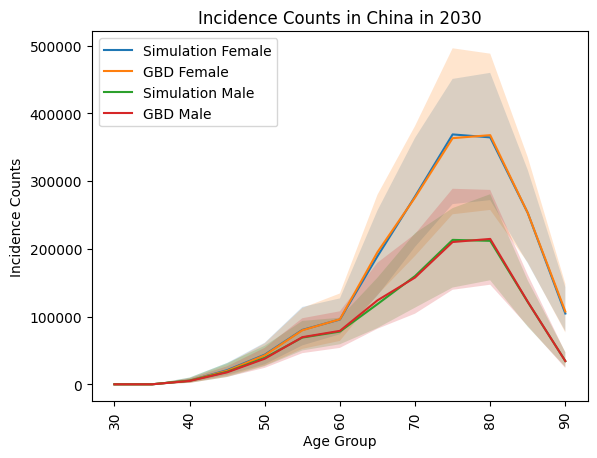

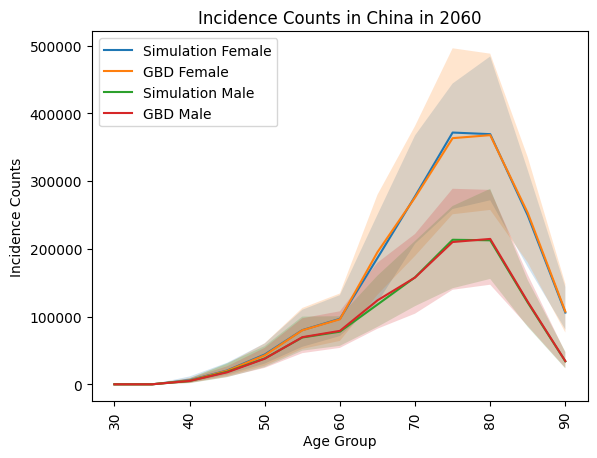

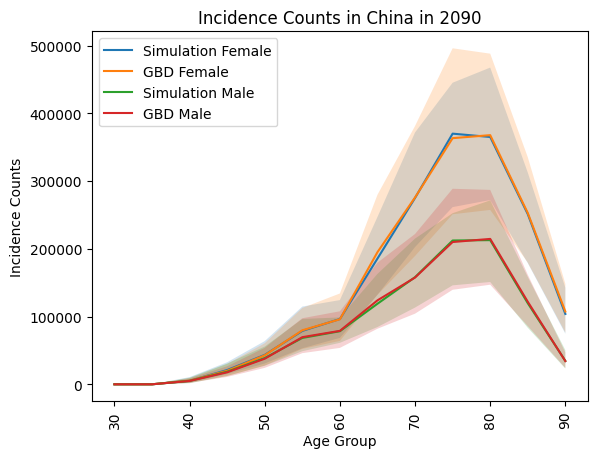

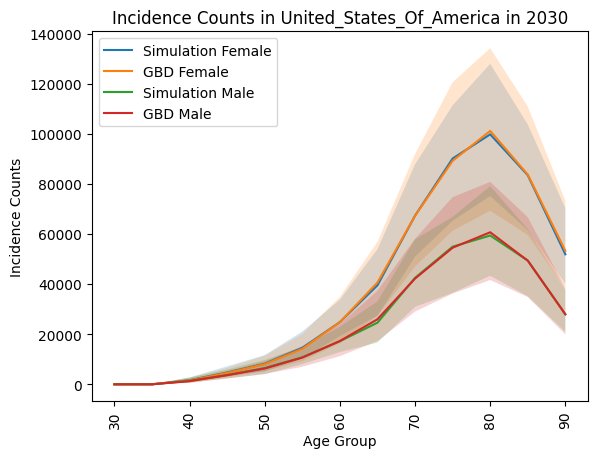

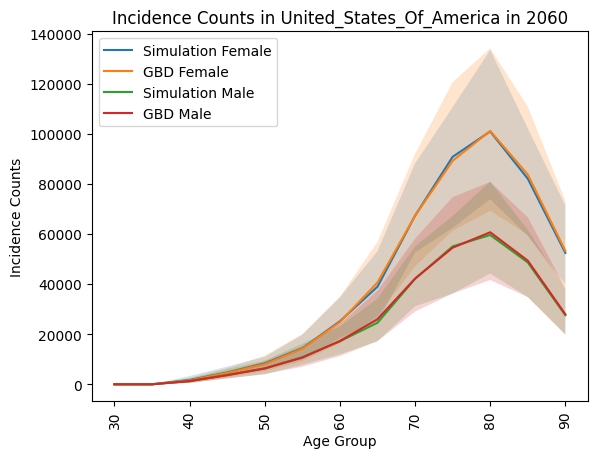

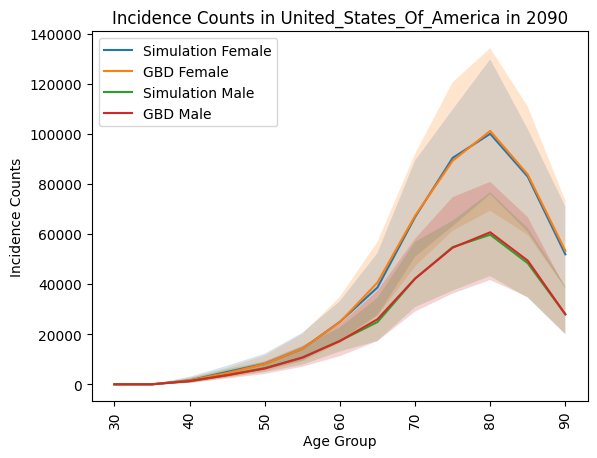

<Figure size 640x480 with 0 Axes>

In [46]:
for location in new_sims.location.unique():
    for year in ['2030','2060','2090']:
        for sex in new_sims.sex.unique():
            plot_data = new_sims.loc[(new_sims.location == location) & (new_sims.current_year == year) & (new_sims.sex == sex) ]
            art_plot = gbd_data.loc[(gbd_data.location_name == location) & (gbd_data.sex == sex) & (gbd_data.measure == 'incidence')]

            plt.plot(plot_data.age_start, plot_data['mean'], label=f'Simulation {sex}')
            plt.fill_between(plot_data.age_start, plot_data['2.5%'], plot_data['97.5%'], alpha=0.2)

            plt.plot(art_plot.age_start, art_plot['val'], label=f'GBD {sex}')
            plt.fill_between(art_plot.age_start, art_plot['upper'], art_plot['lower'], alpha=0.2)

            plt.title(f"Incidence Counts in {location} in {year}")
            plt.tick_params(axis='x', labelrotation=90)
            plt.xlabel("Age Group")
            plt.ylabel(f"Incidence Counts")
            plt.legend()
        plt.figure()

## Verifying Prevalence

In [50]:
cols = ['input_draw','current_year','location','age_group','sex']

new_sims = load_df('person_time_alzheimers_disease_and_other_dementias')
new_sims = new_sims.merge(scale[['location','sex','age_group','ratio']], on= ['location','sex','age_group'])
new_sims['total_prev'] = new_sims['value'] / new_sims['ratio']
new_sims = new_sims.groupby(cols).sum()
new_sims = new_sims.groupby([c for c in cols if c != 'input_draw']).describe(percentiles=[0.025,0.975])['total_prev'].reset_index()

new_sims = new_sims.merge(age_dictionary, on=['age_group'])
new_sims = new_sims.loc[new_sims['age_group_id'].isin(age_group_ids)]
new_sims.head()

/tmp/ipykernel_376917/4093920625.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  new_sims = new_sims.groupby(cols).sum()


,current_year,location,age_group,sex,count,mean,std,min,2.5%,50%,97.5%,max,age_group_id,age_group_name,age_start,age_end
0,2025,China,30_to_34,Female,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11,30 to 34,30.0,35.0
1,2025,China,30_to_34,Male,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11,30 to 34,30.0,35.0
2,2025,United_States_Of_America,30_to_34,Female,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11,30 to 34,30.0,35.0
3,2025,United_States_Of_America,30_to_34,Male,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11,30 to 34,30.0,35.0
4,2026,China,30_to_34,Female,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11,30 to 34,30.0,35.0


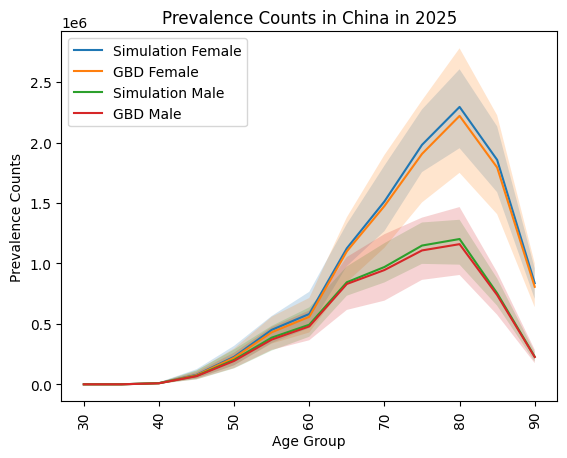

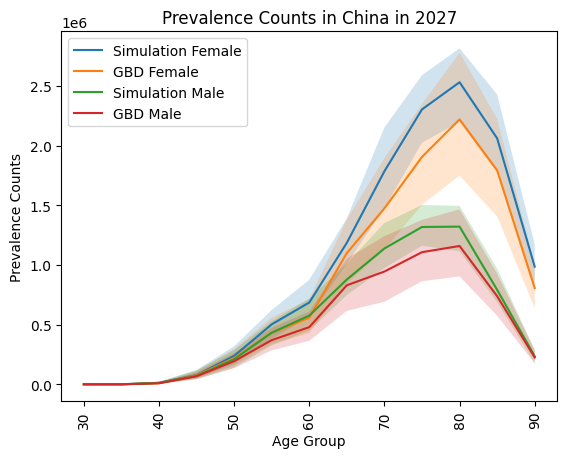

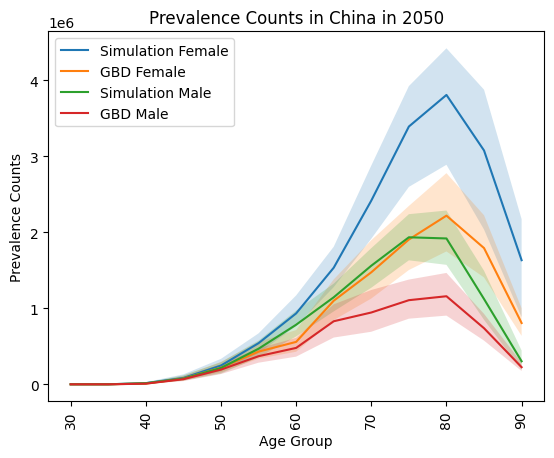

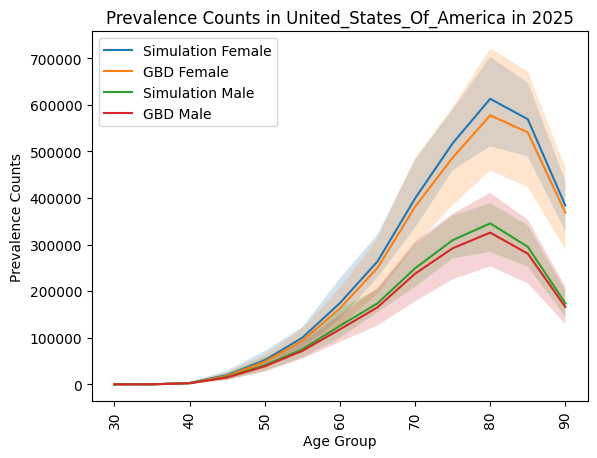

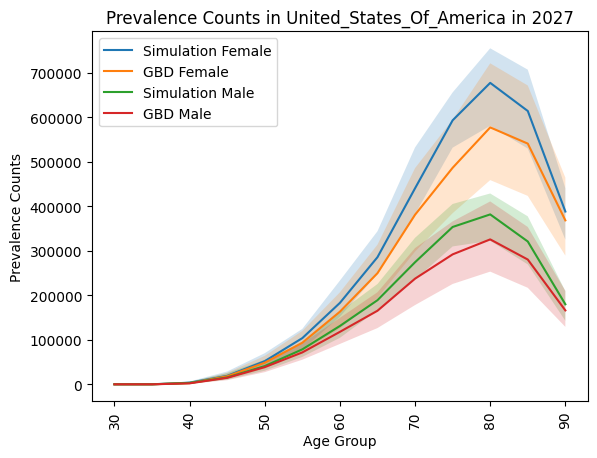

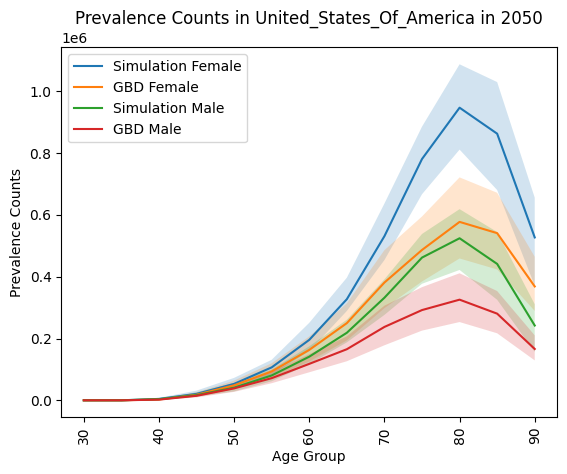

<Figure size 640x480 with 0 Axes>

In [56]:
for location in new_sims.location.unique():
    for year in ['2025','2027','2050']:
        for sex in new_sims.sex.unique():
            plot_data = new_sims.loc[(new_sims.location == location) & (new_sims.current_year == year) & (new_sims.sex == sex) ]
            art_plot = gbd_data.loc[(gbd_data.location_name == location) & (gbd_data.sex == sex) & (gbd_data.measure == 'prevalence')]

            plt.plot(plot_data.age_start, plot_data['mean'], label=f'Simulation {sex}')
            plt.fill_between(plot_data.age_start, plot_data['2.5%'], plot_data['97.5%'], alpha=0.2)

            plt.plot(art_plot.age_start, art_plot['val'], label=f'GBD {sex}')
            plt.fill_between(art_plot.age_start, art_plot['upper'], art_plot['lower'], alpha=0.2)

            plt.title(f"Prevalence Counts in {location} in {year}")
            plt.tick_params(axis='x', labelrotation=90)
            plt.xlabel("Age Group")
            plt.ylabel(f"Prevalence Counts")
            plt.legend()
        plt.figure()

## Total Population Over Time 

In [42]:
cols = ['input_draw','current_year','location'] #, 'age_group']

person_time_total = load_df('person_time_alzheimers_disease_and_other_dementias')
person_time_total = person_time_total.groupby(cols)['value'].sum().reset_index()
person_time_total = person_time_total.groupby([c for c in cols if c != 'input_draw'])['value'].describe(percentiles=[0.025,0.975]).reset_index()
person_time_total.head()

,current_year,location,count,mean,std,min,2.5%,50%,97.5%,max
0,2025,China,25.0,102084.750062,414.668842,101167.811088,101169.013552,102112.246407,102656.862423,102658.365503
1,2025,United_States_Of_America,25.0,101890.131253,414.656770,100993.954825,101166.207803,101952.919918,102479.198357,102514.069815
2,2026,China,25.0,109202.696016,1968.029541,104844.845996,104901.662423,109313.503080,111835.972074,112019.047228
3,2026,United_States_Of_America,25.0,108097.591458,1912.725192,104178.981520,104672.593018,108778.907598,110675.794661,110920.796715
4,2027,China,25.0,115573.090103,3400.389269,108039.392197,108215.853799,115741.174538,120173.156468,120287.991786


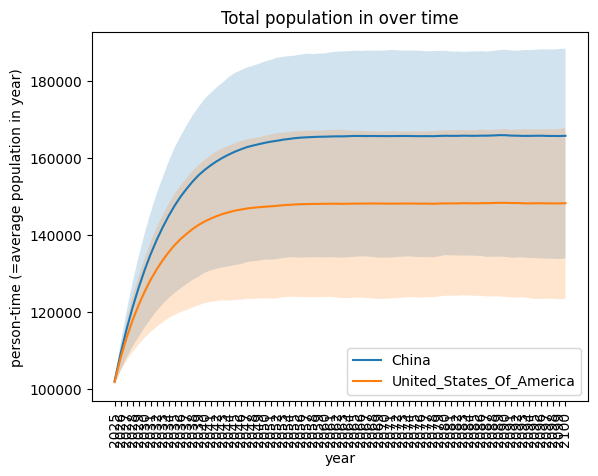

In [43]:
for location in person_time_total.location.unique():
    plot_data = person_time_total.loc[(person_time_total.location == location)]
    plt.plot(plot_data.current_year, plot_data['mean'], label=location)
    plt.fill_between(plot_data.current_year, plot_data['2.5%'], plot_data['97.5%'], alpha=0.2)
    plt.title(f"Total population in over time")
    plt.tick_params(axis='x', labelrotation=90)
    plt.xlabel("year")
    plt.ylabel("person-time (=average population in year)")
    plt.legend()